













































































































































































































## Vamos a usar la librería "dtaidistance"

https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [1]:
import pandas._libs.testing as _testing
import numpy as np
import pandas as pd
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt
from datetime import datetime

### VARIABLES DE ENTRADA

In [2]:
## Ruta al archivo donde están los archivos con la data
path_data = "Data_Train/"
## Nombre del archivo donde está la data
file_data = "27f_3m_CL APR23.Last.txt"

## Ruta del archivo donde están los patrones
path_patterns ="Data_Patron/"
## Nombre del archivo donde está el patrón
file_pattern = "Momentum.csv"

# Ruta de los archivos de salida:
path_output = "Output_Train/"
## Nombre del archivo de salida (tanto el csv como el HTML)
nombre_output = "Momentum_Incremento"

### Lectura y formateo de la data

In [3]:
def fecha(data, dia):
    data["Date"] = data["ds"].str[0:8]
    data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d").dt.date
    data["Time"] = data["ds"].str[9:15]
    data["Time"] = pd.to_datetime(data["Time"], format="%H%M%S").dt.time
    data["ds"] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))
    if dia != None:
        data = data[data["ds"].dt.day == dia]
    return data

    
df = pd.read_csv(path_data + file_data, sep=";", names=["ds", "Open", "High", "Low", "Close", "Volume"])
df = fecha(df, None)
df["signo_vela"] = df["Close"] - df["Open"] #si es positivo --> alcista; si negativo --> bajista
df["signo_vela_anterior"] = df["signo_vela"].shift(1).fillna(0)
df.loc[(df["signo_vela_anterior"]<=0) & (df["signo_vela"]>=0), "Price"] = df["High"]
df.loc[(df["signo_vela_anterior"]>=0) & (df["signo_vela"]>=0), "Price"] = df["High"]
df.loc[(df["signo_vela_anterior"]>=0) & (df["signo_vela"]<=0), "Price"] = df["Low"]
df.loc[(df["signo_vela_anterior"]<=0) & (df["signo_vela"]<=0), "Price"] = df["Low"]

<Axes: xlabel='ds'>

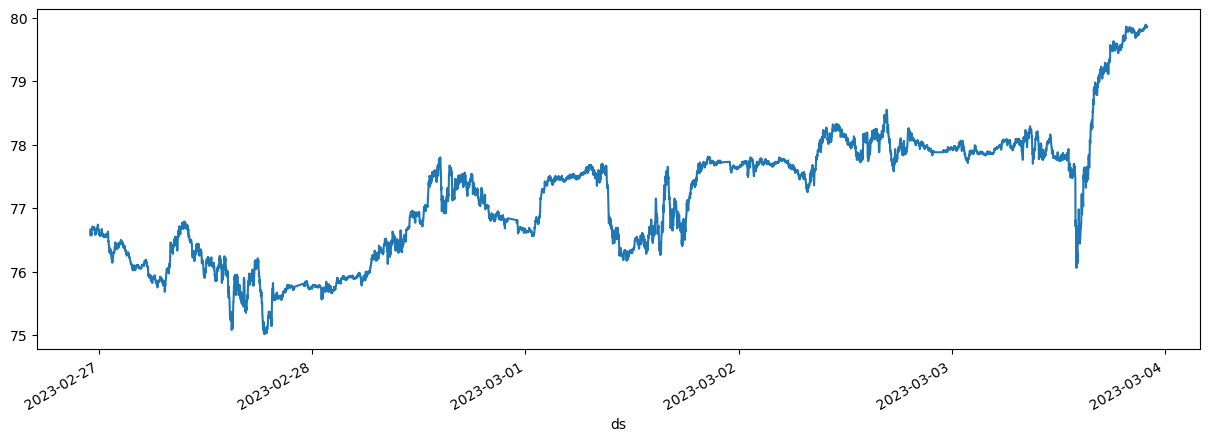

In [4]:
df.set_index("ds")["Close"].plot(figsize=(15,5))

## SCANNER

In [5]:
%%time
def standard_scale(ts):
    return (ts - np.mean(ts))/np.std(ts)

def dtw_distance(x):
    global s1
    x = standard_scale(x)
    distance = dtw.distance_fast(x.values, s1, use_pruning=True)
    return distance

df1 = pd.read_csv(path_patterns + file_pattern, sep=";")
df1.head()

CPU times: total: 0 ns
Wall time: 3.01 ms


,ds,Open,High,Low,Close,Volume,Date,Time,idx,signo_vela,signo_vela_anterior,Price,diferencia_abs
0,2023-03-06T19:18:00,80.19,80.19,80.14,80.18,326,06/03/2023,19:18:00,1215,-0.01,0.00,76.14,0.003280
1,2023-03-06T19:19:00,80.18,80.20,80.15,80.16,305,06/03/2023,19:19:00,1216,-0.02,-0.01,76.17,0.436493
2,2023-03-06T19:20:00,80.16,80.17,80.11,80.17,290,06/03/2023,19:20:00,1217,0.01,-0.02,76.20,-0.091192
3,2023-03-06T19:21:00,80.17,80.25,80.16,80.23,380,06/03/2023,19:21:00,1218,0.06,0.01,76.25,0.148052
4,2023-03-06T19:22:00,80.23,80.25,80.20,80.24,455,06/03/2023,19:22:00,1219,0.01,0.06,76.29,-0.369249


In [6]:
%%time
def standard_scale(ts):
    return (ts - np.mean(ts))/np.std(ts)

def dtw_distance(x):
    global s1
    x = standard_scale(x)
    distance = dtw.distance_fast(x.values, s1, use_pruning=True)
    return distance


df1 = pd.read_csv(path_patterns + file_pattern, sep=";")
s1 = df1["Price"].values
s1 = standard_scale(s1)

df["distance"] = df["Price"].rolling(window=len(s1)+10, center=False).apply(lambda x: dtw_distance(x))  

CPU times: total: 1.02 s
Wall time: 1.95 s


<Axes: >

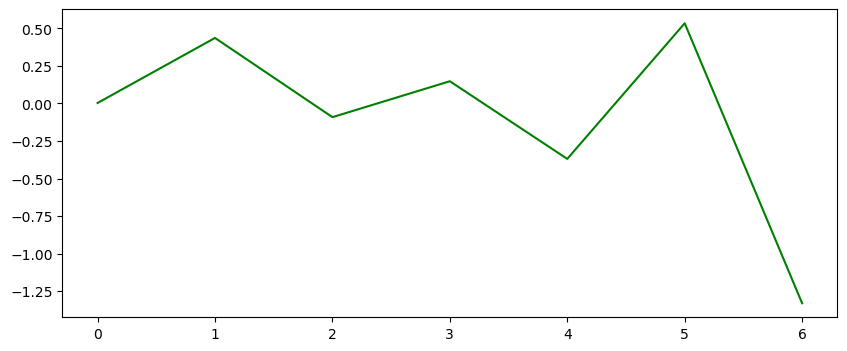

In [7]:
df1["diferencia_abs"].plot(c="green", figsize=(10,4))

<Axes: >

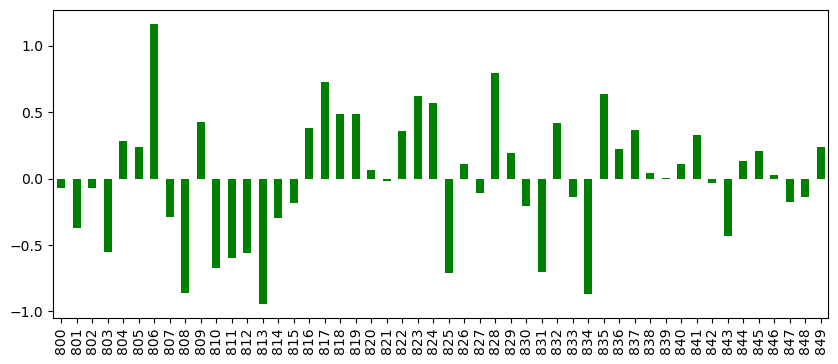

In [8]:
df['diferencia_abs'] = df['distance'].diff(periods=1)
df["diferencia_abs"].iloc[800:850].plot.bar(color="green", figsize=(10, 4))

<Axes: >

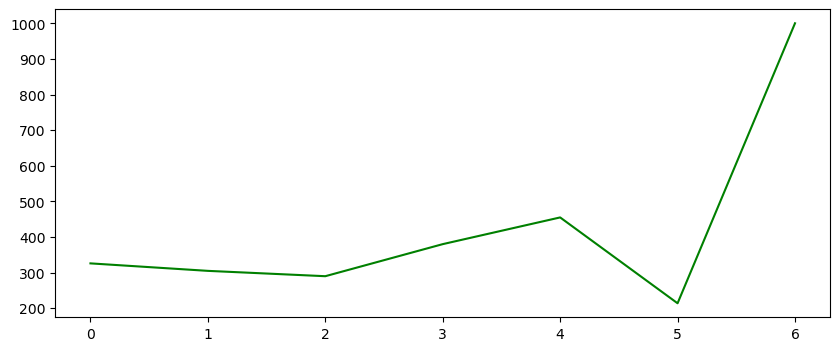

In [9]:
df1["Volume"].plot(c="green", figsize=(10,4))

### Establecer el valor máximo de distancia

In [10]:
## Valor límite de distancia por debajo del cual vamos a seleccionar los patrones
maximo = 3.7

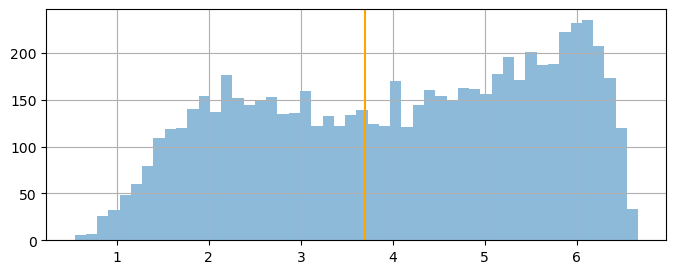

In [11]:
df["distance"].hist(figsize=(8,3), bins=50, alpha=0.5)
plt.axvline(x=maximo, c="orange")

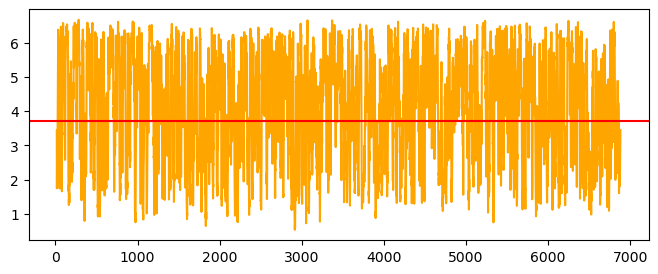

In [12]:
df["distance"].plot(figsize=(8,3), c="orange")
plt.axhline(y=maximo, c="red")

In [13]:
## ATR para asegurarnos zonas con velas suficientemente grandes
df["close_open"] = np.abs(df["Close"] - df["Open"])
df["atr"] = df["close_open"].rolling(window=14).mean()
df["atr"].describe()

count    6868.000000
mean        0.025981
std         0.019322
min         0.002143
25%         0.012143
50%         0.021429
75%         0.035000
max         0.221429
Name: atr, dtype: float64

### Determinamos las entradas

In [14]:
df = df.reset_index(drop = True)
df["filtered"] = False
atr_th = df["atr"].quantile(0.5)


df.loc[(df["atr"]>df["atr"].median()) &\
       (df["distance"]<maximo),
       "filtered"] = True


df["filtered_sum"] = df["filtered"].rolling(window=len(s1), center=False).sum()
df["entrada"] = False
df.loc[(df["filtered_sum"]==1) & (df["filtered"]==True), "entrada"] = True

df.loc[:, 'breakout_region'] = np.where(
        df['entrada'],
        df['High'].max(),
        df['Low'].min()
    )

df["breakout_region"].value_counts()

74.99    6772
79.90     109
Name: breakout_region, dtype: int64

In [15]:
#Creación de un subset con la zona a analizar
inicio = 1170
fin = 1250
suave= 3

# Acotamos el rango a estudiar y la media de periodos incremental
df['diferencia_abs'] = df['distance'].diff(periods=1)
df['diferencia'] = df['diferencia_abs'].rolling(window=suave).mean()
pd.set_option('display.max_rows', None) 
db_subset =  df[['ds','Close','distance','diferencia_abs','diferencia','Volume']][inicio:fin]

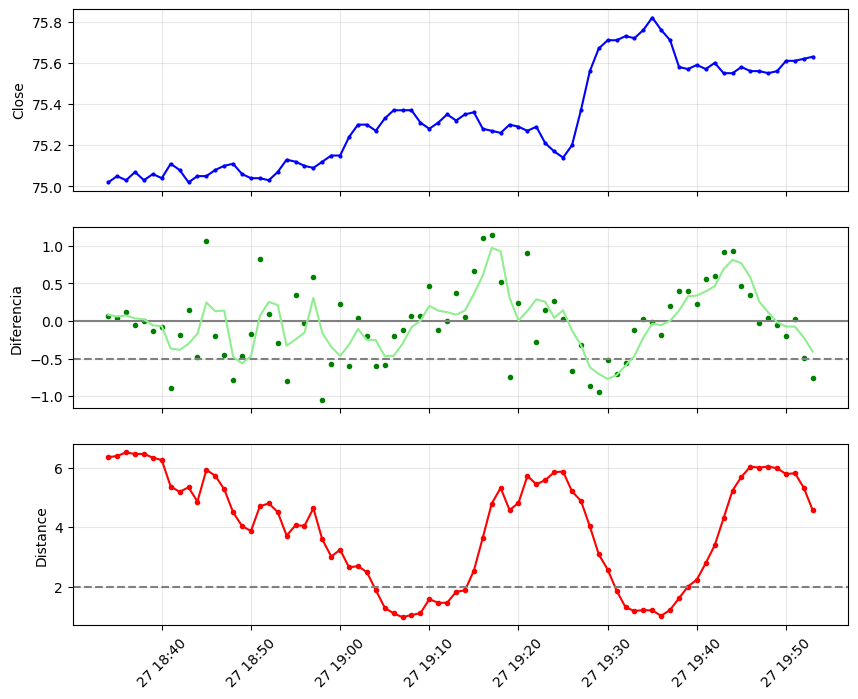

In [16]:
# Analisis decremental del valor 'diferencia'

x = db_subset['ds']
y1 = db_subset['Close']
y2 = db_subset['diferencia_abs']
y3 = db_subset['distance']
y4 = db_subset['diferencia']

fig, ax = plt.subplots(3, 1,sharex=True, figsize=(10, 8)) 
ax[0].plot(x, y1, color='blue',marker='o',markersize=2)
ax[0].set_ylabel('Close')
ax[0].grid(alpha=0.3)

ax[1].plot(x, y2, color='green', marker='o',markersize=3, linestyle='none')
ax[1].set_ylabel('Diferencia')
ax[1].axhline(y=0, color='grey', linestyle='-')
ax[1].axhline(y=-0.5, color='grey', linestyle='--')
ax[1].plot(x, y4, color='lightgreen')
ax[1].grid(alpha=0.3)

ax[2].plot(x, y3, color='red',marker='o',markersize=3, )
ax[2].set_ylabel('Distance')
ax[2].axhline(y=2, color='grey',linestyle='--')
ax[2].grid(alpha=0.3)
ax[2].tick_params(axis='x', rotation=45)

plt.show()

In [17]:
# atención: no es tan importante la bajada del valor de ['Distance'], sino encontrar un valor grande  absoluto, un 'achuchón'
# podemos permanecer en el trade mientras el valor 'acuchón' siga por debajo de cierto valor
# Lo que busco es crear una "ventana", es decir, un estado en el que el robot esté en estado de "atento", en otras palabras,
# adelantar la entrada y que no tenga que coincidir el valor de distance on el del volumen alto.
db_subset

,ds,Close,distance,diferencia_abs,diferencia,Volume
1170,2023-02-27 18:34:00,75.02,6.355081,0.060616,0.082309,999
1171,2023-02-27 18:35:00,75.05,6.396223,0.041143,0.059912,351
1172,2023-02-27 18:36:00,75.03,6.515523,0.119300,0.073686,412
1173,2023-02-27 18:37:00,75.07,6.461267,-0.054257,0.035395,269
1174,2023-02-27 18:38:00,75.03,6.466220,0.004954,0.023332,243
1175,2023-02-27 18:39:00,75.06,6.339804,-0.126416,-0.058573,226
1176,2023-02-27 18:40:00,75.04,6.257396,-0.082408,-0.067957,265
1177,2023-02-27 18:41:00,75.11,5.368537,-0.888859,-0.365894,711
1178,2023-02-27 18:42:00,75.08,5.188345,-0.180193,-0.383820,232
1179,2023-02-27 18:43:00,75.02,5.341473,0.153129,-0.305308,313


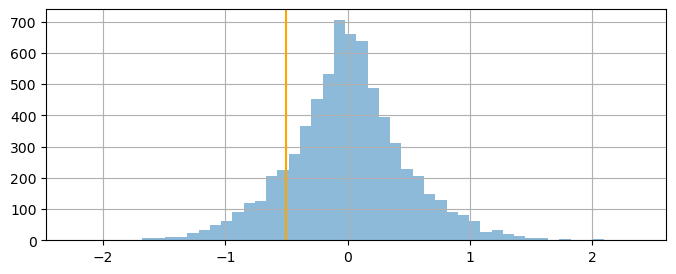

In [18]:
df["diferencia_abs"].hist(figsize=(8,3), bins=50, alpha=0.5)
plt.axvline(x=-0.5, color='orange')

In [19]:
bins = [-float('inf'), -0.5, float('inf')]
labels = ['<0.5', '>=0.5']
pd.cut(df["diferencia_abs"], bins=bins, labels=labels).value_counts()

>=0.5    5939
<0.5      925
Name: diferencia_abs, dtype: int64

In [20]:
# Transformación de los valores negativos incrementales en positivos
df['diferencia_abs_neg'] = df['diferencia_abs'].apply(lambda x: abs(x)*3 if x < 0 else 0)

df[['ds','diferencia','diferencia_abs','diferencia_abs_neg']][790:860].head(300)


,ds,diferencia,diferencia_abs,diferencia_abs_neg
790,2023-02-27 12:14:00,-0.078768,-0.323174,0.969521
791,2023-02-27 12:15:00,-0.066997,0.142357,0.000000
792,2023-02-27 12:16:00,0.099362,0.478904,0.000000
793,2023-02-27 12:17:00,0.168218,-0.116605,0.349816
794,2023-02-27 12:18:00,0.234112,0.340037,0.000000
795,2023-02-27 12:19:00,0.395487,0.963029,0.000000
796,2023-02-27 12:20:00,0.595600,0.483733,0.000000
797,2023-02-27 12:21:00,0.759061,0.830421,0.000000
798,2023-02-27 12:22:00,0.405512,-0.097620,0.292860
799,2023-02-27 12:23:00,0.570748,0.979444,0.000000


In [21]:
# Disparador Volumen
volume_threshold = 250
df.loc[(df["breakout_region"]==df["High"].max()) &\
       (df["Volume"]>=volume_threshold) &\
       ((df["Close"] - df["Open"])>0), "volume_marker"] = df["Close"]

In [22]:
# Volumen Alto
volume_threshold = 500
df.loc[(df["Volume"]>=volume_threshold) &\
       ((df["Close"] - df["Open"])>0), "climatico"] = df["Close"]

In [23]:
# Disparador Achuchon _ la versión anterior contenía error en: >=achuchon_threshold
achuchon_threshold = -0.5
df.loc[(df["breakout_region"]==df["High"].max()) &\
       (df["diferencia_abs"]<=achuchon_threshold) &\
       ((df["Close"] - df["Open"])>0), "achuchon"] = df["Close"]

In [24]:
## Genera un archivo csv con todas las columnas calculadas hasta el mommento
## Se le puede poner el nombre que se quiera
now = datetime.now().strftime("%Y%m%d_%H%M%S")
df.to_csv(f"{path_output}{nombre_output}_{now}.csv", sep=";", index=False)

### Creamos el HTML con el gráfico de salida

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [26]:
def plot_result(df: pd.DataFrame):

    df["color"] = "blue"
    df["color2"] = "brown"
    df.loc[df["climatico"]==df["Close"],"color"] = "Orange"
    df.loc[df["entrada"]==True,"color"] = "black"
    df.loc[df["volume_marker"]==df["Close"],"color"] = "red"
    df.loc[df["achuchon"]==df["Close"],"color"] = "yellow"
    df.loc[df["diferencia_abs_neg"]==df["Close"],"color"] = "white"
  
    
    # Create subplots and mention plot grid size
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                   vertical_spacing=0.05,
                   row_width=[0.2, 0.2, 0.6])

    ## Gráfico con las velas
    fig.add_trace(
        go.Candlestick(
            x = df['ds'],
            open = df['Open'],
            high = df['High'],
            low = df['Low'],
            close = df['Close'],
            showlegend = False,        
        ), row=1, col=1
    )

    # Gráfico con las zonas en verde donde encuentra los patrones
    fig.add_trace(
        go.Scatter(
            x = df['ds'], 
            y = df['breakout_region'],
            fill = 'tonexty',
            fillcolor = 'rgba(0, 236, 109, 0.5)',
            mode = 'lines',
            line = {'width': 2, 'shape': 'hvh','color':'rgba(0, 236, 109, 0.5)'},
            showlegend = False,
        ), row=1, col=1
    )

    # Gràfico con los valores absolutos de INCREMENTO, se han eliminado los valores positivos  
    #fig.add_trace(go.Bar(x=df['ds'], y=df['diferencia_abs_neg'], showlegend=False, marker_color=df["color"]), row=2, col=1)
    

    fig.add_trace(go.Bar(x=df['ds'], y=df['diferencia_abs_neg'], showlegend=False, marker_color=df["color"]), row=2, col=1)

    fig.update_layout(
        yaxis=dict(
            range=[0,2.251]
        )
    )

   
    # Marca la flecha en Volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['volume_marker']+0.05,
            marker=dict(
                color='rgba(0, 206, 250, 0.5)',
                size=7,
                symbol = "diamond",
                line=dict(
                    color='Black',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )

    # Marca un cuadrado con achuchón extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['achuchon']+0.09,
            marker=dict(
                color='Yellow',
                size=7,
                symbol = "square",
                line=dict(
                    color='Black',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )
    
    
    # Marca un círculo donde existe volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['climatico']-0.01,
            marker=dict(
                color='rgba(255, 188, 121, 0.9)',
                size=7,
                symbol = "circle",
                line=dict(
                    color='Black',
                    width=1
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )
    
    # Gráfico de barras con el Volumen
    fig.add_trace(go.Bar(x=df['ds'], y=df['Volume'], showlegend=False,
                        marker_color=df["color2"]), row=3, col=1)

    fig.update_layout(
        yaxis = {'range': [df['Low'].min(), df['High'].max()], 'title': 'Price ($)'},
        yaxis2 = {'range': [0, df['distance'].max()], 'title': 'Abs(INCR x 3'},
        yaxis3 = {'range': [0, df["Volume"].quantile(0.97)], 'title': 'Volume'})


    fig.update(layout_xaxis_rangeslider_visible=False)


    ## Se crea el HTML con el que "jugar"
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig.write_html(f"{path_output}{nombre_output}_{now}.html")


plot_result(df)